In [1]:
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
import shapely
import geemap
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import lil_matrix

import location
import plotting
import scienceplots
import constants as c

plt.style.use(['science','no-latex'])

data_dir = os.path.join('data','brvehins')
tmp_dir  = os.path.join('data', 'tmp')

# Data loading

The file `data/brvehins_raw.parquet` was generated by loading data from the R package `CASdatasets` and then saving it as a parquet file. Since this may require R to be installed, we omit it from this repository to avoid R as a dependency.

In [2]:
raw_path = os.path.join(data_dir,'brvehins_raw.parquet')
df = pd.read_parquet(raw_path)

secrets_path = '.secrets.json'
with open(secrets_path) as f:
    secrets = json.load(f)

[FATAL] 2023-11-26 16:42:48.400 Aws::Config::ConfigFileProfileFSM [0x20c7e2500] Unknown parser error: unexpected state 4


# Data summary

In [3]:
df.columns

Index(['VehYear', 'VehModel', 'VehGroup', 'City', 'CityCode', 'Area', 'State',
       'StateAb', 'ExposTotal', 'PremTotal', 'ClaimNbRob', 'ClaimNbColl',
       'ClaimNbFire', 'ClaimNbOther', 'ClaimAmountRob', 'ClaimAmountColl',
       'ClaimAmountFire', 'ClaimAmountOther'],
      dtype='object')

In [4]:
df.head(3)

,VehYear,VehModel,VehGroup,City,CityCode,Area,State,StateAb,ExposTotal,PremTotal,ClaimNbRob,ClaimNbColl,ClaimNbFire,ClaimNbOther,ClaimAmountRob,ClaimAmountColl,ClaimAmountFire,ClaimAmountOther
0,2011,Ford - Fiesta 1.0 8v Flex 5p,Ford Fiesta 1.0,Ipeuna,352110.0,Ribeirao Preto e Demais Mun. de Campinas,Sao Paulo,SP,0.51,383.40,0,0,0,0,0,0.0,0,0
1,2003,Gm - Chevrolet - S10 P-up 2.8/sert. 2.8 4x4 Tb...,Gm Chevrolet S-10,Monte Alto,353130.0,Ribeirao Preto e Demais Mun. de Campinas,Sao Paulo,SP,0.50,818.95,0,0,0,0,0,0.0,0,0
2,1998,Gm - Chevrolet - Corsa Wagon Gls 1.6 16v Mpfi 4p,Gm Chevrolet Corsa Acima De 1.0,Ribeirao Das Neves (ver Cep Por Logradouros),NaN,Met.BH-Centro Oeste-Zona Mata-C. Vertentes,Minas Gerais,MG,0.17,175.05,0,0,0,0,0,0.0,0,0


In [5]:
df.isnull().sum(axis=0).sort_values(ascending=False).head(8)

CityCode           993672
VehGroup           141384
VehModel           141384
City                 2020
VehYear                 0
ClaimNbColl             0
ClaimAmountFire         0
ClaimAmountColl         0
dtype: int64

In [6]:
df.ExposTotal.min(), df.ExposTotal.max()

(0.0, 2963.26)

In [7]:
df['PremTotal'].max(), df['ClaimAmountRob'].max()

(4317833.7, 1689159)

### Unique value counts for geo units

In [8]:
for col in ['Area', 'City', 'CityCode', 'State', 'StateAb']:
    print(f"# of unique values for column {col}: {df[col].nunique()}")

# of unique values for column Area: 40
# of unique values for column City: 3417
# of unique values for column CityCode: 1627
# of unique values for column State: 27
# of unique values for column StateAb: 27


## Policies per state

In [9]:
print(df['State'].value_counts().sort_values(ascending=False).head(5))
print(df['State'].value_counts().sort_values(ascending=False).tail(5))

State
Sao Paulo            860584
Minas Gerais         346948
Rio Grande do Sul    339644
Parana               289200
Santa Catarina       251648
Name: count, dtype: int64
State
Piaui       5112
Acre        2632
Amapa       2184
Roraima     2040
Rondonia    1928
Name: count, dtype: int64


## Value counts for number of claims, per claim category

In [10]:
n_claim_cols = [col for col in df.columns if 'ClaimNb' in col]

for c in n_claim_cols:
    print(df[c].value_counts().sort_values(ascending=False).head(6))

ClaimNbRob
0    2632696
1      27840
2       4284
3       1132
4        608
5        316
Name: count, dtype: int64
ClaimNbColl
0    2441388
1     162388
2      32108
3      11732
4       5796
5       3252
Name: count, dtype: int64
ClaimNbFire
0    2666332
1       1368
2         44
3          4
6          4
Name: count, dtype: int64
ClaimNbOther
0    2491556
1      87884
2      30616
3      16528
4       9764
5       6388
Name: count, dtype: int64


AttributeError: 'str' object has no attribute 'VISUALS_DIR'

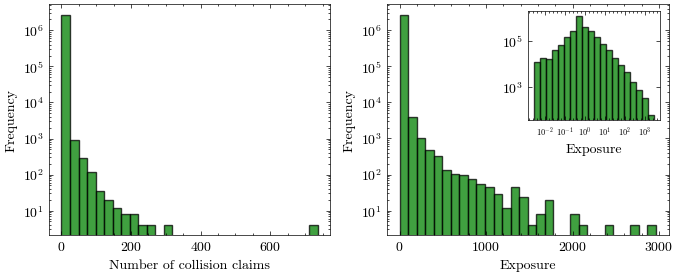

In [11]:
# Make histogram of ClaimNbColl with log10 scale on y-axis

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].hist(df['ClaimNbColl'], bins=30, log=True, edgecolor='k', color='g', alpha=0.75)
axes[0].set_ylabel('Frequency'), axes[0].set_xlabel('Number of collision claims')

axes[1].hist(df['ExposTotal'], bins=30, log=True, edgecolor='k', color='g', alpha=0.75)
axes[1].set_xlabel('Exposure'), axes[1].set_ylabel('Frequency')


# Add inset axes to second plot showing log10 exposure distribution
axins = axes[1].inset_axes([0.5, 0.5, 0.47, 0.47])
axins.hist(np.log10(df.query('ExposTotal > 0')['ExposTotal']), bins=20, log=True, edgecolor='k', color='g', alpha=0.75)

# For the inset set the xticks at -2 up to 3 and label with 10^-2 up to 10^3
axins.set_xticks(np.arange(-2, 4))
axins.set_xticklabels([f'$10^{{{x}}}$' for x in np.arange(-2, 4)], fontsize=6)
axins.set_xlabel('Exposure')

plt.savefig(os.path.join(c.VISUALS_DIR, 'brvehins-hist.png'), dpi=400, bbox_inches='tight')


## Unique value counts for vehicle descriptions

In [ ]:
len(df['VehModel'].unique()), len(df['VehGroup'].unique())

(3891, 412)

## Histogram of nonzero claim amounts (in Brazilian Reals)

Note that the USD-BRL exchange rate used to be 1 to 2 around 2011. Current values are ~1 to 5.

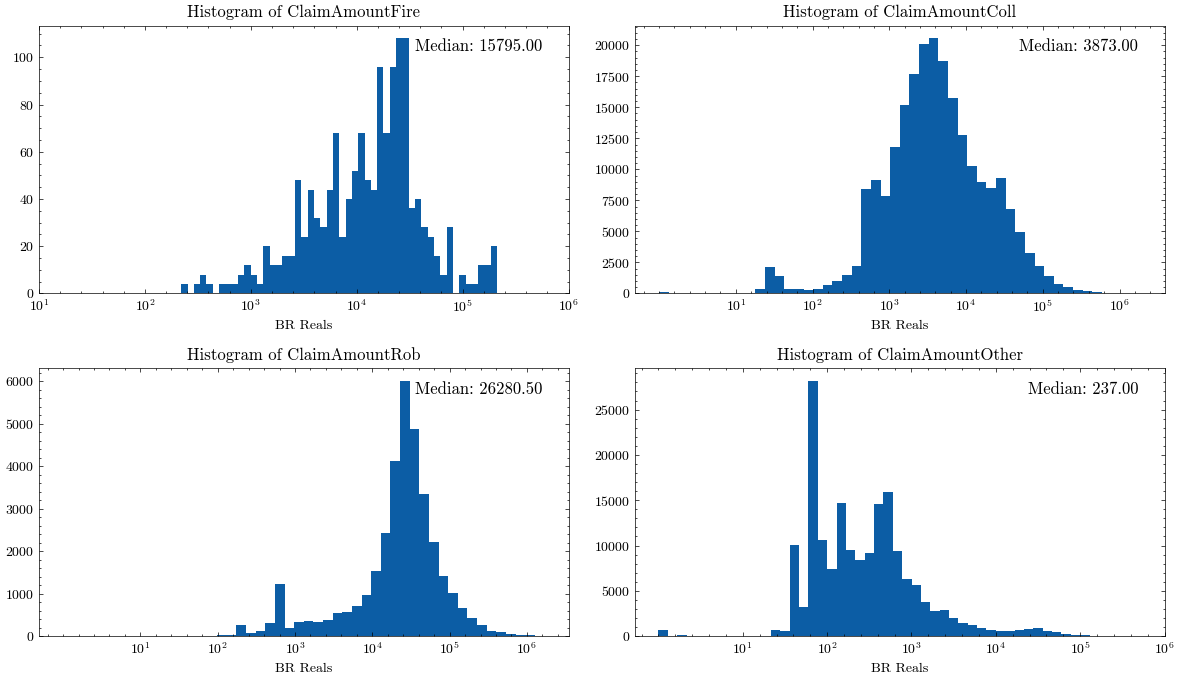

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(12,7))

axes = axes.flatten()

claim_cols = ['ClaimAmountFire', 'ClaimAmountColl', 'ClaimAmountRob', 'ClaimAmountOther']

for i, col in enumerate(claim_cols):
    nonzero_rows = df.query(f'{col} > 0')[col]

    # Histogram in log 10 values
    axes[i].hist(np.log10(nonzero_rows), bins=50)
    axes[i].set_title(f'Histogram of {col}')
    # Add median in upper right
    median = nonzero_rows.median()
    axes[i].text(0.95, 0.95, f'Median: {median:.2f}', transform=axes[i].transAxes, fontsize=12, horizontalalignment='right', verticalalignment='top')

    # Change tickmarkers to reflect log10 USD prices
    xvals = range(1,7)
    axes[i].set_xticks(xvals)
    axes[i].set_xticklabels([f'$10^{{{x}}}$' for x in xvals])
    axes[i].set_xlabel('BR Reals')

plt.tight_layout()

### Ratio of Premiums to Exposure

In [ ]:
df['PremToExpos'] = df['PremTotal'] / df['ExposTotal']

# Get quantiles of PremToExpos
quantiles = df['PremToExpos'].quantile([0.25, 0.5, 0.75])
print(quantiles)

0.25     640.480000
0.50     957.361818
0.75    1538.240185
Name: PremToExpos, dtype: float64


### Ratio of paid claims to premiums

Text(0.5, 0, 'Claim amount / premium amount)')

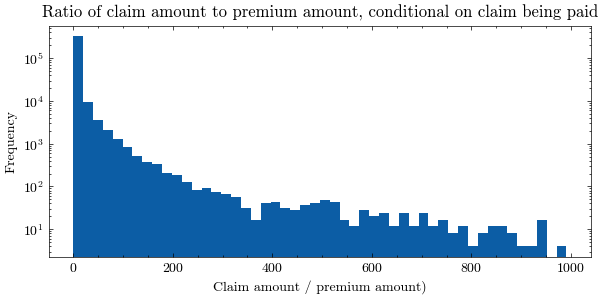

In [12]:
df['ClaimAmountCombined'] = df['ClaimAmountFire'] + df['ClaimAmountColl'] + df['ClaimAmountRob'] + df['ClaimAmountOther']
df['ClaimToPrem'] = df['ClaimAmountCombined'] / df['PremTotal']

# For rows in which a claim was paid, we want the histogram of the ratio
# of the claim amount to the premium amount
was_paid = df.query('ClaimAmountCombined > 0 and PremTotal > 0 and ClaimToPrem < 1000')['ClaimToPrem']

# Make hist with log bins
plt.figure(figsize=(7,3))
plt.hist(was_paid, bins=50, log=True)
plt.title("Ratio of claim amount to premium amount, conditional on claim being paid")
plt.ylabel("Frequency")
plt.xlabel("Claim amount / premium amount)")


## Log-exposure histogram

### Scatter plot for log exposure against claim count

(-3.0, 6.0)

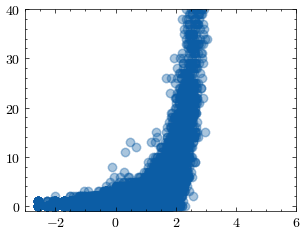

In [14]:
nonzero_exposure_df = df.query('ExposTotal > 0')
plt.scatter(np.log10(nonzero_exposure_df['ExposTotal']), nonzero_exposure_df['ClaimNbColl'], alpha=0.1)
plt.ylim(-1, 40)
plt.xlim(-3, 6)

# Data cleaning

## Dropping vehicles with ages outside of [1971, 2011]

In [15]:
is_outside_years = np.logical_or(df['VehYear'] < 1971, df['VehYear'] > 2011)
print(f"Dropping {is_outside_years.sum()} rows with VehYear outside of 1971-2011")
df = df[~is_outside_years]
df['VehYearSince1971'] = df['VehYear'] - 1971

Dropping 944 rows with VehYear outside of 1971-2011


## Drop rows with zero exposure

In [16]:
# Get number of rows with zero exposure
print(f"Number of rows with zero exposure: {(df['ExposTotal'] == 0).sum()}")
df = df.query("ExposTotal > 0")
print(f"Number of rows with zero exposure after dropping: {(df['ExposTotal'] == 0).sum()}")

Number of rows with zero exposure: 8436
Number of rows with zero exposure after dropping: 0


## Simplifying vehicle model taxonomy

In [17]:
# Replace null / NaN values in VehGroup and VehModel with "Unknown"
print(f"Number of rows with null VehGroup: {(df['VehGroup'].isnull()).sum()}")
df['VehGroup'].fillna('Unknown', inplace=True)
print(f"Number of rows with null VehGroup after dropping: {(df['VehGroup'].isnull()).sum()}")
df['VehModel'].fillna('Unknown', inplace=True)

Number of rows with null VehGroup: 141004
Number of rows with null VehGroup after dropping: 0


In [18]:
# Load the category mapping file
# and apply it to the vehicle group
category_filepath = os.path.join(data_dir,'veh_categories.json')

with open(category_filepath) as f:
    category_map = json.load(f)

df['VehCategory'] = df['VehGroup'].map(category_map)

# Map all null / nan to unknown
df['VehCategory'].fillna('Unknown', inplace=True)
df['VehCategory'].unique()

array(['Hatchback', 'Pickup', 'Truck', 'Motorcycle', 'Minivan', 'Sedan',
       'Unknown', 'Wagon', 'SUV', 'Others', 'Van', 'Sports Car', 'Bus',
       'Compact', 'Coupe'], dtype=object)

In [19]:
# Extract the brand (i.e. VW, Ford) from the model field
df['VehBrand'] = df['VehModel'].str.rsplit(' - ', n=1, expand=True)[0]

# Replace 'Vw - Volkswagen' with 'Volkswagen'
df['VehBrand'] = df['VehBrand'].str.replace('Vw', 'Volkswagen')
df['VehBrand'].unique()

array(['Ford', 'Gm - Chevrolet', 'Mercedes-benz', 'Honda', 'Peugeot',
       'Volkswagen', 'Toyota', 'Unknown', 'Fiat',
       'Volkswagen - Volkswagen', 'Citroen', 'Renault', 'Suzuki', 'Dodge',
       'Scania', 'Chevrolet', 'Mitsubishi', 'Land Rover', 'Outros',
       'Subaru', 'Hyundai', 'Volvo', 'Kia Motors', 'Yamaha', 'Iveco',
       'Harley-davidson', 'Agrale', 'Bmw', 'Alfa Romeo', 'Seat', 'Gmc',
       'Saab-scania', 'Husqvarna', 'Ssangyong', 'Kawasaki', 'Audi',
       'Nissan', 'Marcopolo', 'Triumph', 'Sundown', 'Chrysler', 'Dafra',
       'Troller', 'Asia Motors', 'Lada', 'Navistar', 'Kasinski',
       'Mahindra', 'Engesa', 'Buell', 'Daewoo', 'Jeep', 'Chana', 'Jaguar',
       'Porsche', 'Hafei', 'Effa', 'Gurgel', 'Am Gen', 'Brm', 'Fym',
       'Amazonas', 'Dayun', 'Jpx', 'Neobus', 'Shineray', 'Traxx',
       'Ferrari', 'Mazda', 'Maserati', 'Brp', 'Daihatsu', 'Cagiva',
       'Haobao', 'Acura', 'Piaggio', 'Lexus', 'Miza', 'Envemo', 'Matra',
       'Garinni', 'Bimota', 'Ktm', 'Pu

### Geocoding city-state strings

In [20]:
# All of the missing city/city codes are for the "Oeste Catarinense" region
# so we replace the NaN cities for rows with Santa Catarina state
# with "Oeste Catarinense"
is_nan_city = df['City'].isnull()
is_sc_state = df['State'] == 'Santa Catarina'
df['City'][is_nan_city & is_sc_state] = "Oeste Catarinense"
df['city-state'] = df['City'] + ', ' + df['State'] + ', Brazil'

n_rows_impute_location = is_nan_city.sum()
print(f"Number of rows with null city: {n_rows_impute_location}")


/var/folders/6x/kygxkvrj2gg1s98_1d7ndy5m0000gn/T/ipykernel_3612/3152828228.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['City'][is_nan_city & is_sc_state] = "Oeste Catarinense"


Number of rows with null city: 2016


In [21]:
# We send requests to the Google Maps Geocoding API with strings
# like ""São Paulo, SP, Brazil" and get back the lat-longs
LOAD_FROM_DISK = True
city_coord_path = os.path.join(data_dir, 'br_city_lat_long.parquet')

if LOAD_FROM_DISK:
    city_df = pd.read_parquet(city_coord_path)
else:
    print("Loading lat-longs from Google Maps API")
    google_maps_api_key = secrets['google_maps_api_key']

    city_df = df[['city-state']].drop_duplicates()

    # Apply the function to each row in the DataFrame
    city_df["lat-long"] = city_df["city-state"].apply(lambda x: location.get_lat_long(x, google_maps_api_key))

    city_df['lat'] = city_df['lat-long'].apply(lambda x: x[0])
    city_df['long'] = city_df['lat-long'].apply(lambda x: x[1])

    # Manually set the lat-long for the cities that the API couldn't find
    manual_lat_longs = {
        "Querencia Do Norte, Parana, Brazil": (-23.083889, -53.483333),
    }

    for city_state, lat_long in manual_lat_longs.items():
        city_df.loc[city_df['city-state'] == city_state, ['lat', 'long']] = lat_long

    # Replace any of the NaN city states with the Oeste Catarinense lat-long
    city_df.lat.fillna(-26.5, inplace=True)
    city_df.long.fillna(-52.5, inplace=True)
    city_df['city-state'].fillna("Oeste Catarinense, Santa Catarina, Brazil", inplace=True)

    city_df.sort_values('city-state', inplace=True)
    city_df['city_idx'] = np.arange(len(city_df))
    city_df.set_index('city_idx', inplace=True, drop=False)

    assert not city_df.lat.isnull().any()
    city_df.to_parquet(city_coord_path)

df = df.merge(city_df[['city-state', 'city_idx']], left_on='city-state', right_on='city-state', how='left')

## Creating adjacency graph

In [22]:
# We need to place all the cities on a graph. To do this, we find the K nearest
# neighbors in geographic space for each city. We start the graph by setting any
# edges equal to 1 for neighbors and 0 for non-neighbors. We symmetrize the graph
# to make it undirected setting an edge to 1 if either city is a neighbor of the other.
locations = np.sort(df['city-state'].unique())
n_locations = len(locations)

# Create a dictionary to map city-state to index
city_state_to_idx = dict(zip(locations, range(n_locations)))

# Create a dictionary to map index to city-state
idx_to_city_state = dict(zip(range(n_locations), locations))

# Means that each site has at least 4 neighbors
k = 5

# Identify k nearest neighbors for each city
# Get lat longs as radians
city_df['lat_rad'] = np.radians(city_df['lat'])
city_df['long_rad'] = np.radians(city_df['long'])

nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree', metric='haversine').fit(city_df[['lat_rad', 'long_rad']])
distances, indices = nbrs.kneighbors(city_df[['lat_rad', 'long_rad']])

# Initialize LIL matrix
adj_graph = lil_matrix((n_locations, n_locations))

# Create the adjacency graph
for i in range(n_locations):
    for j in indices[i]:
        adj_graph[i, j] = 1

# Convert to CSR format and symmetrize the graph
# and making sure all elements are 0 or 1
adj_graph = adj_graph.tocsr()
adj_graph = adj_graph + adj_graph.T
adj_graph = adj_graph.sign()

# Connect any unconnected components
adj_graph = location.connect_components(city_df, adj_graph)

# Make sure diagonals are set to zero
adj_graph.setdiag(0)

# Print maximum degree of the graph
print(adj_graph.sum(axis=0).max())

# Print out location with most neighbors
max_idx = adj_graph.sum(axis=0).argmax()
print(idx_to_city_state[max_idx])

print(f"The sparsity of the graph is {adj_graph.nnz / (n_locations**2)}")

# Save the graph to disk
adj_graph_path = os.path.join(data_dir, 'city_graph.npz')
scipy.sparse.save_npz(adj_graph_path, adj_graph)


39.0
Aguas Vermelhas, Rio Grande do Sul, Brazil
The sparsity of the graph is 0.0015767587064980482


/Users/madeline/venvs/bas-venv/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Visualizing adjacency graph

In [23]:
# Make a plot showing sites and edges between sites in
# the vicinity of latitudes -28 to -26 and
# longitudes -52 to -50
lat_min = -26
lat_max = -22
lon_min = -51   
lon_max = -47

folium_map = plotting.plot_cities_with_folium(city_df, adj_graph, lat_min, lat_max, lon_min, lon_max, add_city_labels=False)
folium_map


## Attaching municipality boundary data

In [26]:
shapefile_path = os.path.join(data_dir,"BR_Municipios_2021", "BR_Municipios_2021.shp")
boundary_gdf = gpd.read_file(shapefile_path)

# Create list of Point geometries for the lat-long in the city_df
city_gdf = gpd.GeoDataFrame(city_df, geometry= [shapely.geometry.Point(xy) for xy in zip(city_df.long, city_df.lat)], crs=boundary_gdf.crs)

# Do spatial join to get the CD_MUN field from gdf on the city_gdf
# This will match on the lat-long
city_gdf = gpd.sjoin(city_gdf, boundary_gdf, how='left', op='within')
city_gdf.geometry = boundary_gdf.set_index('CD_MUN').loc[city_gdf.CD_MUN]['geometry'].values

# Make sure none of the geometries are missing
assert not city_gdf.geometry.isnull().any()

# Use this for EE queries
city_gdf[['city-state', 'geometry']].to_file(os.path.join(data_dir, 'city_regions.shp'))

/Users/madeline/venvs/bas-venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


## Zonal stats from Earth Engine

In [27]:
import geojson
import ee
ee.Initialize()
ee.Reducer.mean()

def gdf_to_fc(gdf):
    '''
    Convert a GeoPandas GeoDataFrame to an Earth Engine FeatureCollection.
    '''

    # Make sure CRS is EPSG:4326
    gdf = gdf.to_crs(epsg=4326)

    all_polys = []
    for idx, row in gdf.iterrows():
        try:
            # Convert the geometry and properties to a geojson Feature
            shpJSON = geojson.Feature(
                geometry = row['geometry'], 
                properties = {key: value for key, value in row.items() if key != 'geometry'}
            )
            # Convert the geojson Feature to an Earth Engine Feature
            ee_feat = ee.Feature(shpJSON)
            all_polys.append(ee_feat)
        except Exception as e:
            print(f"feature {idx} is invalid: {e}")

    # Create an Earth Engine FeatureCollection
    return ee.FeatureCollection(all_polys)

### Define layers to target for Earth Engine zonal statistics

In [28]:
zonal_tasks = [
    {
        'image_id':"JRC/GSW1_4/GlobalSurfaceWater",
        'band': 'occurrence',
        'label':'Water',
        'stat_name': 'mean'
    },
    {
        'image_id': 'WorldPop/GP/100m/pop/BRA_2011',
        'band': 'population',
        'label':'Population',
        'stat_name': 'mean'
    },
    {
        'image_id':'MODIS/061/MOD13A3/2011_01_01',
        'band': 'EVI',
        'label':'Vegetation',
        'stat_name': 'mean'
    },
    {
        'image_id':"CGIAR/SRTM90_V4",
        'band': 'elevation',
        'label':'Elevation',
        'stat_name': 'mean'
    },
    {
        'image_id':"CSP/ERGo/1_0/Global/ALOS_topoDiversity",
        'band':'constant',
        'label':'Topography',
        'stat_name': 'mean'
    },
    {
        'image_id':"JAXA/ALOS/PALSAR/YEARLY/FNF4/2017",
        'band':'fnf',
        'label':'Forest',
        'stat_name': 'mean'
    },
    {
        'image_id':"Oxford/MAP/friction_surface_2019",
        'band':'friction',
        'label':'Motorized travel',
        'stat_name': 'mean'
    },
    {
        'image_id':"Oxford/MAP/friction_surface_2019",
        'band':'friction_walking_only',
        'label':'Nonmotorized travel',
        'stat_name': 'mean'
    },
    {
        'image_id':'WORLDCLIM/V1/MONTHLY/12',
        'band':'prec',
        'label':'Rainfall',
        'stat_name': 'mean'
    }
]

In [29]:

def retrieve(features, task, stat='MEAN'):
    '''
    Gets zonal statistics for an image from Earth Engine, loading it as a CSV.

    Parameters
    ----------
    features : ee.FeatureCollection or gpd.GeoDataFrame
        The features to get zonal statistics for
    task : dict
        A dictionary with keys 'image_id', 'band', and 'label'. Each of these
        should be a string. For example, the image_id for the JRC Global Surface
        Water dataset is "JRC/GSW1_4/GlobalSurfaceWater" and one of the bands is
        'occurrence'. The label is the name of the column in the output dataframe and
        we can freely choose what to call it.

    Returns
    -------
    zonal_df : pd.DataFrame
        A dataframe with a single column containing the zonal statistics for each feature in features
    '''
    out_path = os.path.join(tmp_dir, f'{task["label"]}.csv')

    if isinstance(features, gpd.GeoDataFrame):
        features = gdf_to_fc(features)

    elif isinstance(features, ee.FeatureCollection):
        pass

    else:
        raise ValueError("features must be a GeoDataFrame or FeatureCollection")

    img = ee.Image(task['image_id']).clip(features).select(task['band'])

    # Since GEEMap downloads a file and doesn't allow for in-memory
    # retrieval, we just delete the file after we're done with it
    geemap.zonal_statistics(
        img, 
        features, 
        statistics_type=stat,
        out_file_path=out_path)

    zonal_df = pd.read_csv(out_path) \
        .drop('system:index', axis=1, errors='ignore') \
        .set_index('city-state') \
        .rename(columns={'mean': task['label']})
    
    os.remove(out_path)
    return zonal_df


### Ingest data from Earth Engine

In [30]:
save_gdf = city_gdf[['city-state', 'geometry']].copy()

# Simplify features by 1000 km in projected CRS
save_gdf.geometry = save_gdf.geometry.to_crs(epsg=3857).simplify(200).to_crs(epsg=4326)
save_gdf.to_file(os.path.join(data_dir, 'city_polygons.gpkg'), driver='GPKG')

In [31]:
features_for_ee             = city_gdf[['city-state', 'geometry']].copy()
features_for_ee['geometry'] = features_for_ee.to_crs(epsg=3857).simplify(1000).to_crs(epsg=4326)
feature_collection          = gdf_to_fc(features_for_ee)

# The tasks are all independent and are just simple zonal averages
# evaluated against a single ee.Image, so we can just map the task dicts.
unary_retrieve = lambda x: retrieve(feature_collection, x)
ee_frames      = map(unary_retrieve, zonal_tasks)

# At this point, we have a list of frames with shared index so we 
# horizontally concatenate them into a single dataframe and report
# on the nullity of each column
ee_df = pd.concat(ee_frames, axis=1)

# Replace population density with np.log10(1+population density)
ee_df['Log10 population'] = np.log10(1+ee_df['Population'])
ee_df.drop('Population', axis=1, inplace=True)

# Merge onto the city_df
city_df = city_df.merge(ee_df, left_on='city-state', right_index=True, how='left')

# for the columns derived from Earth Engine, count the nulls, report on them,
# and use median imputation
for col in ee_df.columns:
    print(f"{col}: {city_df[col].isnull().sum()} nulls")
    print(f"{col}: {city_df[col].isnull().mean()*100:.2f}% nulls")
    city_df[col].fillna(city_df[col].median(), inplace=True)

city_df.head(3)

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /Users/madeline/Dropbox/research/bayes-at-scale/data/tmp/Water.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /Users/madeline/Dropbox/research/bayes-at-scale/data/tmp/Population.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /Users/madeline/Dropbox/research/bayes-at-scale/data/tmp/Vegetation.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /Users/madeline/Dropbox/research/bayes-at-scale/data/tmp/Elevation.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /Users/madeline/Dropbox/research/bayes-at-scale/data/tmp/Topography.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /Users/madeline/Dropbox/research/bayes-at-scale/data/tmp/Forest.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /Users/madeline/Dropbox/r

,city-state,lat-long,lat,long,city_idx,lat_rad,long_rad,Water,Vegetation,Elevation,Topography,Forest,Motorized travel,Nonmotorized travel,Rainfall,Log10 population
city_idx,,,,,,,,,,,,,,,,
0,"Abadia Dos Dourados, Minas Gerais, Brazil","[-18.4868648, -47.4030649]",-18.486865,-47.403065,0,-0.322657,-0.827340,66.969501,4481.523846,775.627482,0.247432,2.448772,0.006071,0.014204,283.515047,0.015194
1,"Abadiania, Distrito Federal, Brazil","[-16.1973129, -48.7060927]",-16.197313,-48.706093,1,-0.282696,-0.850082,54.289511,5223.934776,980.201395,0.281292,2.519782,0.006011,0.014774,250.360435,0.041055
2,"Abadiania, Goias, Brazil","[-16.1973129, -48.7060927]",-16.197313,-48.706093,2,-0.282696,-0.850082,54.289511,5223.934776,980.201395,0.281292,2.519782,0.006011,0.014774,250.360435,0.041055


### Plot of correlation across predictors

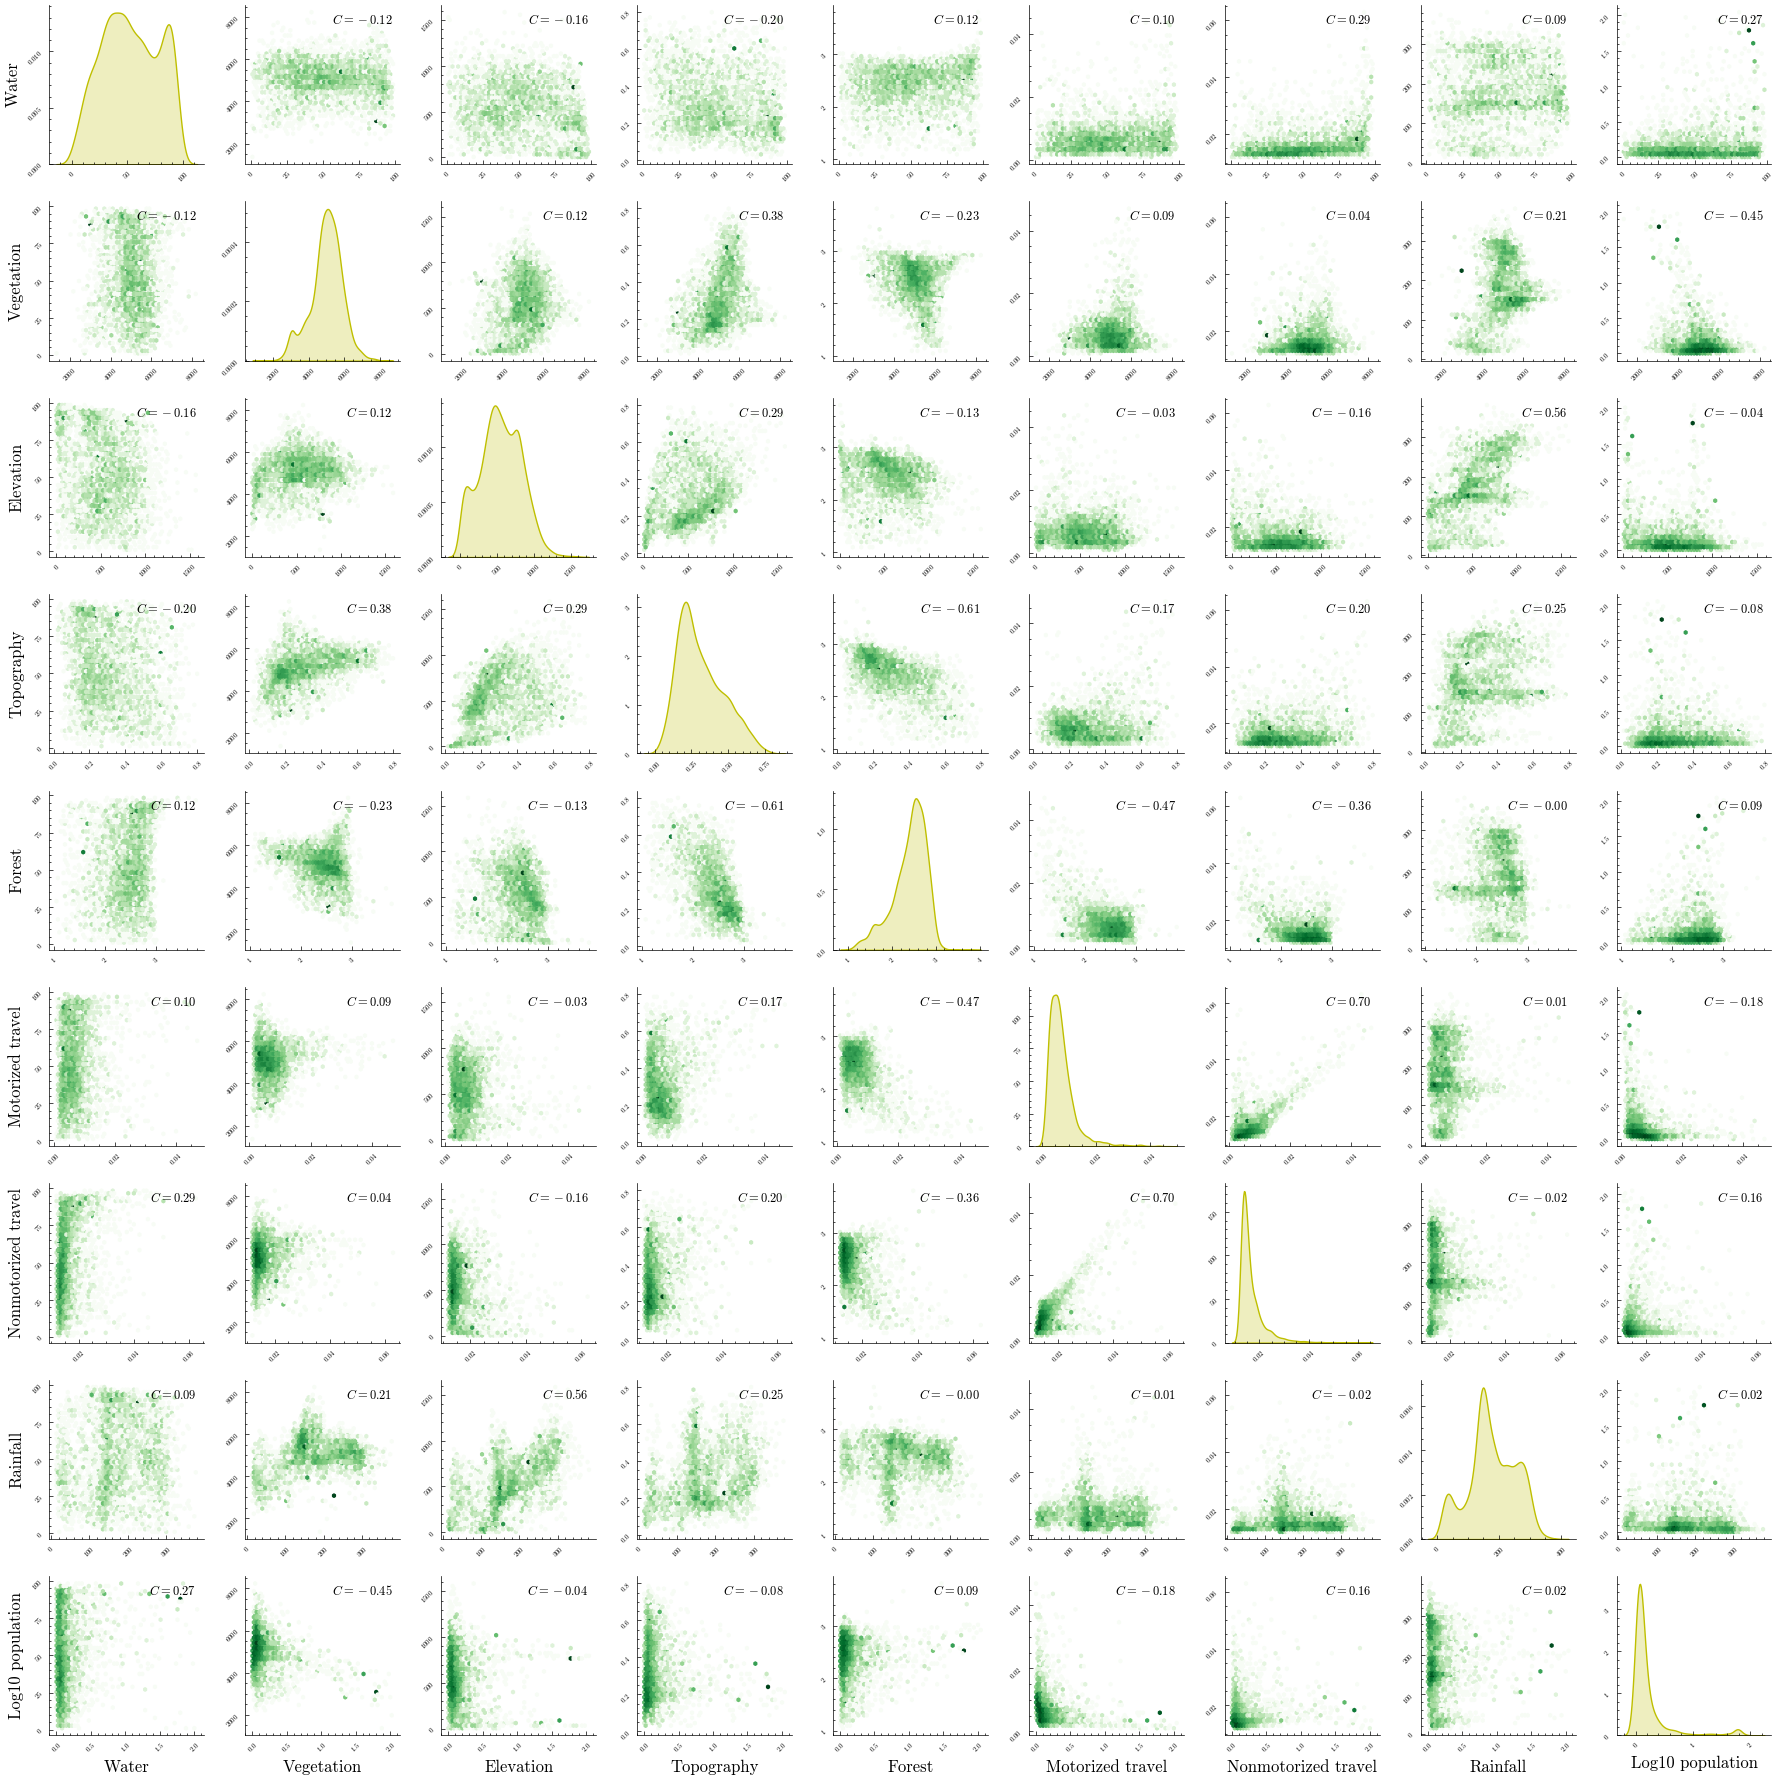

In [32]:
n_ee_cols = len(ee_df.columns)

fig, axes = plt.subplots(n_ee_cols, n_ee_cols, figsize=(n_ee_cols*2, n_ee_cols*2))
for i, col1 in enumerate(ee_df.columns):
    for j, col2 in enumerate(ee_df.columns):
        if i == j:
            #plt.text(0.5, 0.5, col1, transform=axes[i, j].transAxes, fontsize=12, horizontalalignment='center', verticalalignment='center')
            sns.kdeplot(ee_df[col1], ax=axes[i, j], fill=True, color='y')
        else:
            axes[i, j].hexbin(ee_df[col1], ee_df[col2], gridsize=50, cmap='Greens', bins='log')

# Turn off all spines except left spine for first column
# and bottom spine for bottom row and also disable
# ticks on these spines
for i, col in enumerate(ee_df.columns):
    for j, col in enumerate(ee_df.columns):
            axes[i, j].spines['right'].set_visible(False)
            axes[i, j].spines['top'].set_visible(False)
        

# Add xlabels to the bottom row
for i, col in enumerate(ee_df.columns):
    axes[n_ee_cols-1, i].set_xlabel(col, fontsize=12)

# Add ylabels to the left column
for i, col in enumerate(ee_df.columns):
    axes[i, 0].set_ylabel(col, fontsize=12)

# For each diagonal, turn off x, y labels
for i, col in enumerate(ee_df.columns):
    if i != 0:
        axes[i, i].set_ylabel('')

    if i != n_ee_cols-1:
        axes[i, i].set_xlabel('')


# For each off-diagonal, add correlation in bold green text in upper right
for i, col1 in enumerate(ee_df.columns):
    for j, col2 in enumerate(ee_df.columns):
        if i != j:
            corr = ee_df[[col1, col2]].corr().iloc[0,1]
            axes[i, j].text(0.95, 0.95, f'$C={corr:.2f}$', transform=axes[i, j].transAxes, fontsize=9, horizontalalignment='right', verticalalignment='top', color='k', fontweight='bold')
        
# Make all x and y tick labels in very small font
for i, col in enumerate(ee_df.columns):
    for j, col in enumerate(ee_df.columns):
        axes[i, j].tick_params(axis='both', which='major', labelsize=5, rotation=45)

        # Make sure labels have at most 4 ticks
        axes[i, j].locator_params(axis='x', nbins=5)
        axes[i, j].locator_params(axis='y', nbins=5)

        # Make sure all ticks point inward
        axes[i, j].tick_params(axis='both', direction='in')
        axes[i, j].tick_params(axis='x', which='both', top=False)
        axes[i, j].tick_params(axis='y', which='both', right=False)

plt.tight_layout()
plt.savefig(os.path.join('visuals', 'brvehins-covariates.pdf'), bbox_inches='tight', dpi=500)

## Converting vehicle category and brand to categories

In [33]:
# convert the VehCategory and VehBrand to categorical
df['VehCategory'] = df['VehCategory'].astype('category')
df['VehBrand'] = df['VehBrand'].astype('category')


## Save to disk

In [34]:
save_cols = [
    'VehYearSince1971','ExposTotal','PremTotal','city_idx',
    'VehCategory','VehBrand',
    'ClaimAmountCombined', 'ClaimAmountFire', 'ClaimAmountColl', 'ClaimAmountRob', 'ClaimAmountOther',
    'ClaimNbFire','ClaimNbColl','ClaimNbRob','ClaimNbOther'
]

clean_path =  os.path.join(data_dir,'brvehins_clean.parquet')

df[save_cols].to_parquet(clean_path)